In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import yfinance as yf
import datetime as dt

In [2]:
def ewmacd(signals,ma1,ma2):
    
    # short span means greater weight is given to the most recent data
    
    signals[f'macd_{ma1}']=signals['Close'].ewm(span=ma1).mean()   
    signals[f'macd_{ma2}']=signals['Close'].ewm(span=ma2).mean()   
    
    return signals

def signal_generation(df, method, ma1, ma2):
    
    signals = method(df, ma1, ma2)
    signals['positions'] = 0
    signals['positions'].iloc[ma1:] = np.where(signals[f'macd_{ma1}'].iloc[ma1:]>=\
                                                    signals[f'macd_{ma2}'].iloc[ma1:]
                                                    , 1, 0)
    signals['signals'] = signals['positions'].diff()
    signals['macd_oscillator'] = signals[f'macd_{ma1}'] - signals[f'macd_{ma2}']
    
    return signals

In [3]:
def portfolio(signals, vol):
        
    capital0=5000

    portfolio=pd.DataFrame()
    portfolio['Close']=signals['Close']

    portfolio['holding']=signals['positions']*portfolio['Close']*vol

    #cash is initial capital minus the profit we make from every trade
    #note that we have to use cumulated sum to add every profit into our cash
    portfolio['cash']=capital0-(signals['signals']*portfolio['Close']*vol).cumsum()
    portfolio['cash'].iloc[0] = capital0
    # here multiply the close price with signals because signals are when we actually make the trade

    portfolio['total_asset']=portfolio['holding']+portfolio['cash']
    portfolio['stock_return']=portfolio['Close'].pct_change()
    portfolio['strategy_return']=portfolio['total_asset'].pct_change()
    
    portfolio['strat_cumulative_return'] = (portfolio['strategy_return'] + 1).cumprod()
    portfolio['base_cumulative_return'] = (portfolio['stock_return'] + 1).cumprod()
    
    
    return portfolio

In [4]:
# visualization

def plot(portfolio, **item):
    # plot the value of the selected item (column)
    items = []
    for i in item.values():
        items.append(i)
    
    portfolio[items].plot(figsize = (16,10))

In [5]:
# performance metrics

def sharpe(portfolio, cond):
    return (portfolio[cond].mean() / \
            portfolio[cond].std()
           ) * np.sqrt(252)

def cagr(portfolio, cond):
    D = (portfolio.index[-1] - portfolio.index[0]).days
    return (portfolio[cond].iloc[-1] / portfolio[cond].iloc[0])**(365/D) - 1

<ipython-input-2-a31ce069a558>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  signals['positions'].iloc[ma1:] = np.where(signals[f'macd_{ma1}'].iloc[ma1:]>=\


Strategy Sharpe ratio: 1.8026556768244104  |  baseline Sharpe ratio: 0.7926315392044009
Strategy CAGR: 542.8024113650096 %  |  baseline CAGR: 44.46689708339508 %
Strategy cumulative return: 1.6065480468749995  |  baseline cumulative return 1.0982674158542542


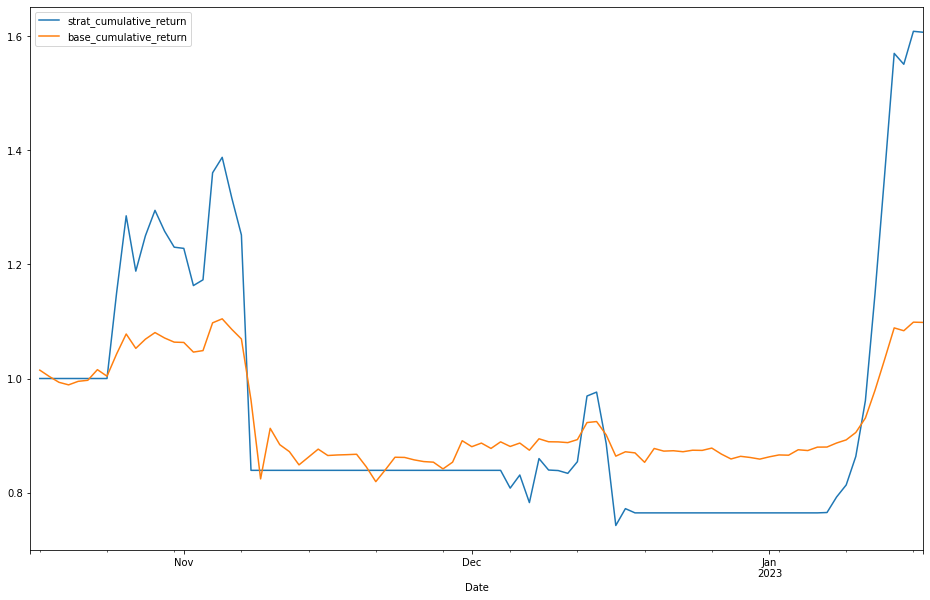

In [23]:
# bitcoin backtesting

# set parameters for strategy
ma1=8
ma2=15
vol = 0.5

#download data
stdate=dt.datetime(2022,10,17)
eddate=dt.datetime(2023,1,18)
ticker='BTC-USD'
df=yf.download(ticker,start=stdate,end=eddate, progress=False)

# trading signals and PnL
signals=signal_generation(df,ewmacd,ma1,ma2)
portfo=portfolio(signals, vol)

# performance metrics
sr_strat = sharpe(portfo, 'strategy_return')
cagr_strat = cagr(portfo, 'total_asset')*100
sr_base = sharpe(portfo, 'stock_return')
cagr_base = cagr(portfo, 'Close')*100
cumuret_strat = portfo.strat_cumulative_return.iloc[-1]
cumuret_base = portfo.base_cumulative_return.iloc[-1]

# results
print(f"Strategy Sharpe ratio: {sr_strat}  |  baseline Sharpe ratio: {sr_base}")
print(f"Strategy CAGR: {cagr_strat} %  |  baseline CAGR: {cagr_base} %")
print(f"Strategy cumulative return: {cumuret_strat}  |  baseline cumulative return {cumuret_base}")

plot(portfo, a='strat_cumulative_return', b='base_cumulative_return')


In [7]:
[portfo.stock_return.std(), portfo.strategy_return.std()]

[0.0283610471543083, 0.033288039356023806]

In [11]:
signals.tail(20)

,Open,High,Low,Close,Adj Close,Volume,macd_8,macd_15,positions,signals,macd_oscillator
Date,,,,,,,,,,,
2022-12-29,16552.322266,16651.755859,16508.683594,16642.341797,16642.341797,14472237479,16742.499128,16816.589265,0,0.0,-74.090138
2022-12-30,16641.330078,16643.427734,16408.474609,16602.585938,16602.585938,15929162910,16711.407308,16789.837802,0,0.0,-78.430495
2022-12-31,16603.673828,16628.986328,16517.519531,16547.496094,16547.496094,11239186456,16674.982593,16759.544051,0,0.0,-84.561458
2023-01-01,16547.914062,16630.439453,16521.234375,16625.080078,16625.080078,9244361700,16663.893145,16742.735551,0,0.0,-78.842406
2023-01-02,16625.509766,16759.343750,16572.228516,16688.470703,16688.470703,12097775227,16669.354825,16735.952267,0,0.0,-66.597442
2023-01-03,16688.847656,16760.447266,16622.371094,16679.857422,16679.857422,13903079207,16671.688735,16728.940251,0,0.0,-57.251515
2023-01-04,16680.205078,16964.585938,16667.763672,16863.238281,16863.238281,18421743322,16714.255301,16745.727842,0,0.0,-31.472540
2023-01-05,16863.472656,16884.021484,16790.283203,16836.736328,16836.736328,13692758566,16741.473307,16757.104102,0,0.0,-15.630795
2023-01-06,16836.472656,16991.994141,16716.421875,16951.968750,16951.968750,14413662913,16788.250072,16781.462558,1,1.0,6.787515


<ipython-input-2-a31ce069a558>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  signals['positions'].iloc[ma1:] = np.where(signals[f'macd_{ma1}'].iloc[ma1:]>=\


Strategy Sharpe ratio: 0.8185344206253395  |  baseline Sharpe ratio: 0.3457898783393454
Strategy CAGR: 16.310182460492694 %  |  baseline CAGR: 6.072313234645232 %
Strategy cumulative return: 1.4059002685546875  |  baseline cumulative return 1.1421610340746506


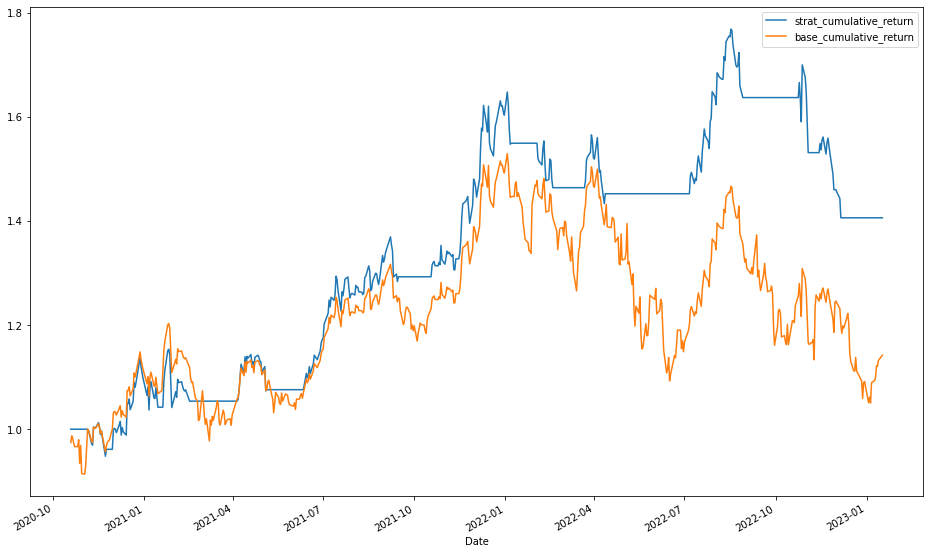

In [20]:
# apple backtesting

# set parameters for strategy
ma1=8
ma2=15
vol = 50

#download data
stdate=dt.datetime(2020,10,17)
eddate=dt.datetime(2023,1,19)
ticker='AAPL'
df=yf.download(ticker,start=stdate,end=eddate, progress=False)

# trading signals and PnL
signals=signal_generation(df,ewmacd,ma1,ma2)
portfo=portfolio(signals, vol)

# performance metrics
sr_strat = sharpe(portfo, 'strategy_return')
cagr_strat = cagr(portfo, 'total_asset')*100
sr_base = sharpe(portfo, 'stock_return')
cagr_base = cagr(portfo, 'Close')*100
cumuret_strat = portfo.strat_cumulative_return.iloc[-1]
cumuret_base = portfo.base_cumulative_return.iloc[-1]

# results
print(f"Strategy Sharpe ratio: {sr_strat}  |  baseline Sharpe ratio: {sr_base}")
print(f"Strategy CAGR: {cagr_strat} %  |  baseline CAGR: {cagr_base} %")
print(f"Strategy cumulative return: {cumuret_strat}  |  baseline cumulative return {cumuret_base}")

plot(portfo, a='strat_cumulative_return', b='base_cumulative_return')



In [22]:
signals.loc['2022-04':'2022-07']

,Open,High,Low,Close,Adj Close,Volume,macd_8,macd_15,positions,signals,macd_oscillator
Date,,,,,,,,,,,
2022-04-01,174.029999,174.880005,171.940002,174.309998,173.524963,78751300,173.720385,170.802919,1,0.0,2.917466
2022-04-04,174.570007,178.490005,174.440002,178.440002,177.636368,76468400,174.769189,171.757555,1,0.0,3.011634
2022-04-05,177.500000,178.300003,174.419998,175.059998,174.271591,73401800,174.833813,172.170360,1,0.0,2.663453
2022-04-06,172.360001,173.630005,170.130005,171.830002,171.056152,89058800,174.166300,172.127815,1,0.0,2.038484
2022-04-07,171.160004,173.360001,169.850006,172.139999,171.364746,77594700,173.716011,172.129338,1,0.0,1.586672
...,...,...,...,...,...,...,...,...,...,...,...
2022-07-25,154.009995,155.039993,152.279999,152.949997,152.484894,53623900,151.454486,148.858499,1,0.0,2.595987
2022-07-26,152.259995,153.089996,150.800003,151.600006,151.139008,55138700,151.486823,149.201187,1,0.0,2.285636
2022-07-27,152.580002,157.330002,152.160004,156.789993,156.313202,78620700,152.665306,150.149788,1,0.0,2.515518


In [9]:
# # def profit(portfolio):
        
# #     gx=plt.figure()
# #     gx.add_subplot(111)

# #     portfolio['macd asset'].plot()

# #     plt.legend(loc='best')
# #     plt.grid(True)
# #     plt.show()
    
# def mdd(series):

#     temp=0
#     for i in range(1,len(series)):
#         if temp>(series[i]/max(series[:i])-1):
#             temp=(series[i]/max(series[:i])-1)

#     return temp


# def stats(portfolio):
    
#     stats=pd.DataFrame([0])

#     #lets calculate some sharpe ratios
#     #note that i set risk free return at 0 for simplicity
#     #alternatively we can use snp500 as a benchmark
#     stats['macd sharpe']=(portfolio['macd asset'].iloc[-1]/5000-1)/np.std(portfolio['macd return'])

#     stats['macd mdd']=mdd(portfolio['macd asset'])

#     #ta-da!
#     print(stats)

